## Import packages

In [5]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
%matplotlib widget
import sys
sys.path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
import coordinates as coord # this one is new!

In [7]:
print(coord.__file__)


/Users/koichikimoto/Desktop/Space/AA179/src/coordinates.py


## Conversion factors between radians, degrees, minutes and seconds

In [8]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

## Spherical coordinates 

In [9]:
x = 1.0
y = 1.0
z = 0.0

[lon, lat, r] = coord.cart2sph(x, y, z)
print(lon * rad2deg, lat * rad2deg, r)

45.0 0.0 1.4142135623730951


## Rotation matrices

We want to get a counterclockwise rotation as seen from a chosen axis. 

In [10]:
R3 = coord.rotation(45 * deg2rad, 3)
print(R3)

[[ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


In [11]:
R1 = coord.rotation(45 * deg2rad, 1)
print(R1)

[[ 1.          0.          0.        ]
 [ 0.          0.70710678  0.70710678]
 [ 0.         -0.70710678  0.70710678]]


## ECI and ECEF systems

In [12]:
filename = '/Users/koichikimoto/Desktop/Space/AA179/ISS_coords.txt' # this is an absolute file path. It will be different for you.
data = np.loadtxt(filename)
t        = data[:,0]  
r_ECEF   = data[:,1:] #data is given in ECEF

### Plotting ISS trajectory in ECEF

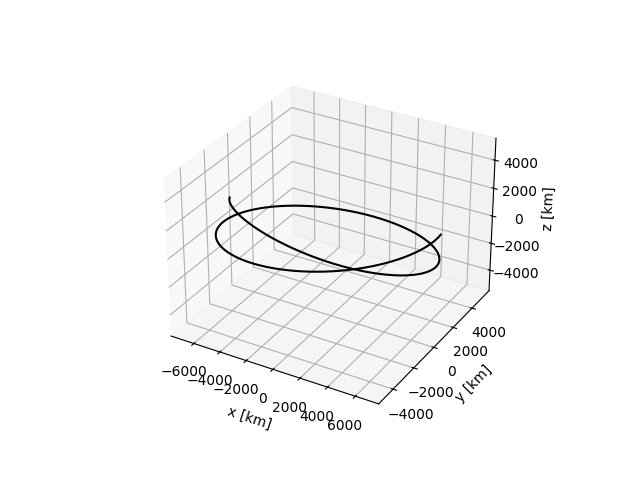

In [13]:
# creating figure 
fig = plt.figure() 
ax  = fig.add_subplot(projection='3d') 

# creating the plot 
plot_3D = ax.plot(r_ECEF[:,0]/1e3, r_ECEF[:,1]/1e3, r_ECEF[:,2]/1e3,'-k')
  
# setting title and labels 
ax.set_xlabel('x [km]') 
ax.set_ylabel('y [km]') 
ax.set_zlabel('z [km]') 
  
# displaying the plot 
plt.show()

### Plotting ISS trajectory in ECI (in inertial space)

Let's first get the angle between ECI and ECEF. Here we follow Eq. 2.85 in Gill & Montenbruck (2000)

In [14]:
JD_J2000 = coord.gregorian2JD(1.0,1.5,2000.0)
JD_J2024 = coord.gregorian2JD(1.0,1.0,2024.0)
d        = JD_J2024 - JD_J2000 + t
S        = (280.4606 + 360.9856473 * (d)) * deg2rad 

Now, let's rotate the ECEF coordinates to get ECI coordinates.

In [15]:
R        = [coord.rotation(-S[i],3) for i in range(len(S))]
r_ECI = np.array([np.dot(R[i],r_ECEF[i,:]) for i in range(len(S))])

Let's plot the orbit in ECI.

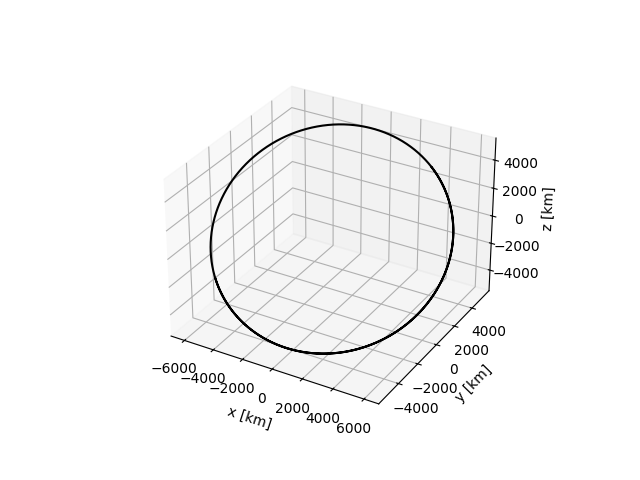

In [16]:
# creating figure 
fig = plt.figure() 
ax  = fig.add_subplot(projection='3d') 

# creating the plot 
plot_3D = ax.plot(r_ECI[:,0]/1e3, r_ECI[:,1]/1e3, r_ECI[:,2]/1e3,'-k') #ECI is used here
  
# setting title and labels 
ax.set_xlabel('x [km]') 
ax.set_ylabel('y [km]') 
ax.set_zlabel('z [km]') 
  
# displaying the plot 
plt.show()

Notice, now it looks like a closed circle.

## Parameters of the Earth

In [17]:
a_ell = 6378137.0 # semimajor axis (m)
c_ell = 6356752.314245 # semiminor axes (m)
e_ell = np.sqrt(1 - c_ell ** 2  / a_ell ** 2) # eccentricity 

## ISS Visibility (PS01 Q3)

83.94758380495657


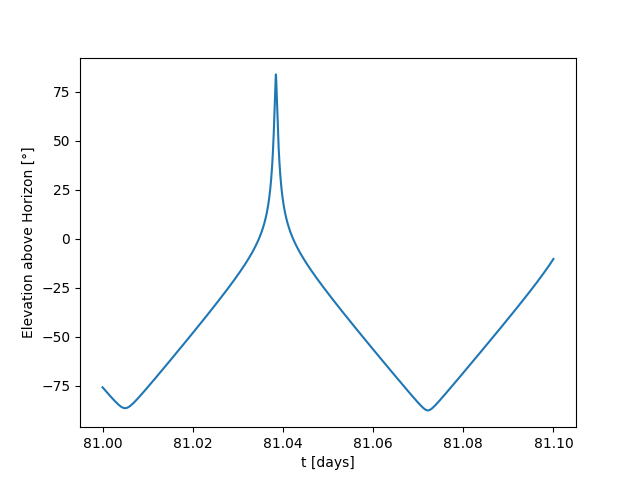

In [18]:
# Main Quad Geodetic coordinates
obs_B = 37.4275 * deg2rad    # geodetic latitude (rad)
obs_L = -122.17 * deg2rad   # longitude (rad)
obs_H = 28                 # height (m)

# Observer position in ECEF
obs_x, obs_y, obs_z = coord.BLH2XYZ(obs_B, obs_L, obs_H, a_ell, e_ell)

# Instantiate array for elevation angles (in rad)
N_data = r_ECEF.shape[0]
elevs = np.zeros(N_data)

# Loop over each ISS ECEF coordinate to compute NEU coordinates and elevation.
for i in range(N_data):
    x_iss, y_iss, z_iss = r_ECEF[i,:]
    # Use (N, E, U) for elevation angle
    N_iss, E_iss, U_iss = coord.XYZ2NEU(x_iss, y_iss, z_iss, obs_x, obs_y, obs_z, a_ell, e_ell)
    # Find elevation
    elevs[i] = np.arctan2(U_iss, np.sqrt(N_iss*N_iss + E_iss * E_iss)) 

# Convert elevs array to radians
elev_deg = elevs * rad2deg

# Find and give max elevation angle
max_elev = np.max(elev_deg)
print(max_elev)

# Plot to show 
plt.figure()
plt.xlabel('t [days]') 
plt.ylabel('Elevation above Horizon [°]') 
plt.plot(t, elev_deg)
# displaying the plot 
plt.show()


### PS01 Q3b

In [19]:
# minimum angle above horizon to see the ISS
min_angle = 0

i_max = np.argmax(elev_deg) # max elevation angle found in previous question
print(f"Max elevation occurs at index:", i_max, "with an elevation of " + str(max_elev) + "°")

# find the initial time (t_i) when ISS rises above horizon by looping backwards
i_i = i_max # prepare initial index 
while i_i > 0 and elev_deg[i_i] > min_angle:
    i_i -= 1
# While loop will go to the index just before ISS goes above horizon
# so we want the index right after
i_i += 1

# do the same for final time (t_f) when ISS dips below horizon 
i_f = i_max
while i_f < N_data - 1 and elev_deg[i_f] > min_angle:
    i_f += 1
i_f -= 1

# so now we have the initial and final index for the max angle pass,find difference in time and voila!
pass_t = t[i_f] - t[i_i] # in days
pass_t_minutes = pass_t * 24 * 60 # pass time in minutes

print("Time for ISS to cross sky for max elevation pass is: " + str(pass_t_minutes))

Max elevation occurs at index: 38440 with an elevation of 83.94758380495657°
Time for ISS to cross sky for max elevation pass is: 10.94986949872009


## Coordinate transformations between Geodetic (Ellipsoidal) and NEU coordinates

In [20]:
# '''
B = 45.0  * deg2rad # ellipsoidal latitude
L = 100.0 * deg2rad # longitude
H = 100.0 # ellipsoidal height
# '''

In [21]:
"""
# Code for Problem 2 PS01
B = 37.427  * deg2rad # ellipsoidal latitude (deg)
L = -122.174 * deg2rad # longitude (deg)
H = 35 # ellipsoidal height (m)
# """

'\n# Code for Problem 2 PS01\nB = 37.427  * deg2rad # ellipsoidal latitude (deg)\nL = -122.174 * deg2rad # longitude (deg)\nH = 35 # ellipsoidal height (m)\n# '

## Hoover Tower to Campanile (PS01 Q2 Bonus)

### Berkeley Campanile Coordinates

In [22]:
# Coordinates of Berkeley campanile (Geodetic)
B_C = 37.872  * deg2rad # ellipsoidal latitude (deg)
L_C = -122.258 * deg2rad # longitude (deg)
H_C = 189 # ellipsoidal height (m)

# Convert to ECEF
(x_C, y_C, z_C) = coord.BLH2XYZ(B_C, L_C, H_C, a_ell, e_ell)

### Hoover Tower Coordinates

In [23]:
# Coordinates of Hoover Tower (Geodetic)
B_H = 37.4275  * deg2rad # ellipsoidal latitude (deg)
L_H = -122.167 * deg2rad # longitude (deg)
H_H = 110 # ellipsoidal height (m)

# Convert to ECEF
(x_H, y_H, z_H) = coord.BLH2XYZ(B_H, L_H, H_H, a_ell, e_ell)

### Find NEU from Hoover to Campanile and compute elevation angle

In [24]:
N_H2C, E_H2C, U_H2C = coord.XYZ2NEU(x_C, y_C, z_C, x_H, y_H, z_H, a_ell, e_ell)
print(N_H2C, E_H2C, U_H2C)

elev_H2C = np.arctan2(U_H2C, np.sqrt(N_H2C * N_H2C + E_H2C * E_H2C)) * rad2deg
print(elev_H2C)


49339.82888550763 -8006.860003469715 -117.42668191439952
-0.1346004361364327


## PS01 Q5 (Durand to Vandenburg)

In [25]:
# Durand Geodetic coordinates
B_D = 37.4271 * deg2rad # ellipsoidal latitude (deg)
L_D = -122.174 * deg2rad # longitude (deg)
H_D = 35 # (m)

# Vandenburg Geodetic Coordinates
B_V = 34.7556 * deg2rad # ellipsoidal latitude (deg)
L_V = -120.622 * deg2rad # longitude (deg)
H_V = 56 # (m)

# Convert from Geodetic to XYZ for Durand and Vandenburg
(x_D, y_D, z_D) = coord.BLH2XYZ(B_D, L_D, H_D, a_ell, e_ell)
(x_V, y_V, z_V) = coord.BLH2XYZ(B_V, L_V, H_V, a_ell, e_ell)

# Compute NEU coords of Vandenburg relative to Durand 
N, E, U = coord.XYZ2NEU(x_V, y_V, z_V, x_D, y_D, z_D, a_ell, e_ell)
print(N, E, U)

# Calculate Azimuth
azimuth_DtoV = np.arctan2(E, N) * rad2deg
print("Azimuth: " + str(azimuth_DtoV))

# Calculate Elevation
elev_DtoV = np.arctan2(U, np.sqrt(N * N + E * E)) * rad2deg
print("Elevation: " + str(elev_DtoV))

-295157.3003733839 142083.07775054104 -8416.338851832203
Azimuth: 154.29472618508575
Elevation: -1.4717683319637809


### Min altitude of vertical rocket to appear above local horizon at Stanford

In [26]:
above_horizon = False
min_altitude = 0

while not above_horizon:
    # Increase altitude @ Vandenburg 
    H_V += 1

    # Convert from Geodetic to XYZ for Durand and Vandenburg
    (x_D, y_D, z_D) = coord.BLH2XYZ(B_D, L_D, H_D, a_ell, e_ell)
    (x_V, y_V, z_V) = coord.BLH2XYZ(B_V, L_V, H_V, a_ell, e_ell)

    # Compute NEU coords of Vandenburg relative to Durand 
    N, E, U = coord.XYZ2NEU(x_V, y_V, z_V, x_D, y_D, z_D, a_ell, e_ell)
    
    elev_DtoV = np.arctan2(U, np.sqrt(N * N + E * E)) * rad2deg

    if elev_DtoV > 0:
        min_altitude = H_V
        break

print(elev_DtoV)
print(min_altitude)

8.458588451871988e-05
8484


Let's convert it to the ECEF Cartesian coordinates

In [27]:
(x, y, z) = coord.BLH2XYZ(B, L, H, a_ell, e_ell)
print(x,y,z)

-784483.702337271 4449028.158851757 4487419.119543847


It is good thing to check if we convert it back, will we get the same coordinates

In [28]:
(B_check, L_check, H_check) = coord.XYZ2BLH(x, y, z, a_ell, e_ell) #checking parameters
print(B_check * rad2deg, L_check * rad2deg, H_check) # print to check and cross reference with inputs

44.999999999999915 100.0 99.99999999906868


In [29]:
# Calculate the distance from the center of Earth by using distance formula in 3D 
d_center = np.sqrt(x*x + y*y + z*z)
print(d_center)


6367589.543299436


Let's move 1 arcminute north and get compute the NEU coordinates of that point

In [30]:
latitudinal_move = 1.0 * min2rad
B_moved = B + latitudinal_move
(x_moved, y_moved, z_moved) = coord.BLH2XYZ(B_moved, L, H, a_ell, e_ell)
N, E, U = coord.XYZ2NEU(x_moved, y_moved, z_moved, x, y, z, a_ell, e_ell)
print(N, E, U)

1852.2280671342737 8.049028110690415e-11 -0.2693957859002012


Does the value of 1852 meters sound familiar?

1 arcsecond is about 31 meters. Good thing to remember.